# Simple Dynamic Mode Decomposition
This assumes that the data given is a $k \times m$: $[x_1, \ldots, x_m]$.
Then the finite-dimension approximation of the Koopman operator acts as the shift operator on this data:
$$Kx_k = x_{k+1}.$$
So that we can pose this as a linear problem:
$$KX = X'$$
where
$$\begin{align}
X &= [x_1, x_2, \ldots, x_{m-1}] \\ 
X' &= [x_2, x_3, \ldots, x_m]
\end{align}.
$$
Then the simple approach is to then to solve this by:
$$K \approx X(X')^{\dagger},$$
where $\dagger$ denotes the Moore-Penrose psuedoinverse.
This can be shown that this minimizes the Frobenius error:
$$K = \arg \min_{W} \|X' - W X\|$$

for $x \in \mathbb{R}$ this will be equivalent to a first-order Autoregressive Model and so it'll be equivalent to linear regression.

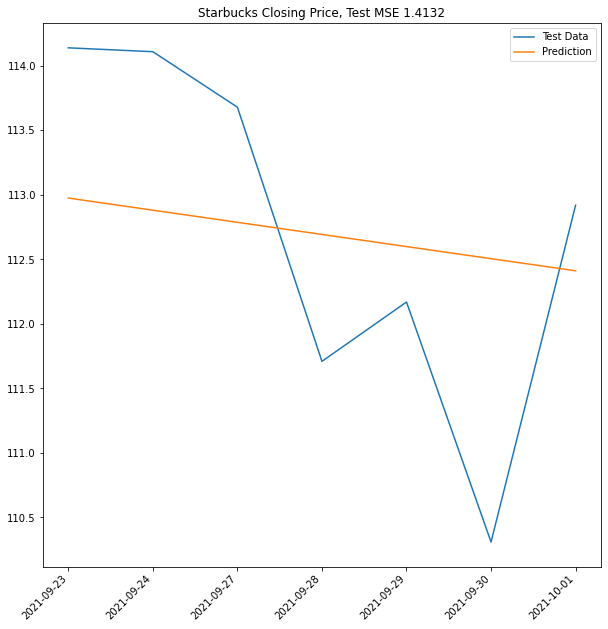

In [1]:
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import torch
import pandas as pd
## Import the data from Kaggle
history = pd.read_csv(r'../input/starbucks-stock-data-live-and-latest/Starbucks_stock_history.csv').set_index("Date")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = history["Close"]
## Split the data for a time-series forecast
train_win = round(X.shape[0]-7)
X_train,X_test = X[:train_win], X[train_win:]
## Define a Training function for the Koopman operator approximation
def train_koopman_predict(X_train):
    ## Take the first m-1 columns
    X_1 = torch.tensor(X_train.values.T[:-1].reshape(1,-1)).to(device)
    ## Take the last m - 1 columns
    X_2 = torch.tensor(X_train.values.T[1:].reshape(1,-1)).to(device)
    ## Define the Koopman Operator approx.
    K = torch.mm(X_1, torch.linalg.pinv(X_2)).to(device)
    ## Helper function for predictions
    predict = lambda X : torch.mm(K,X)
    ## Loss on the training set
    train_loss = mse_loss(predict(X_1),X_2)
    return predict, train_loss
## Get the predictor
predict,train_loss = train_koopman_predict(X_train)
## The last value of the training set to predict the first value of the test set
X_0 = torch.tensor(X_train.values[-1].reshape(-1,1)).to(device)

## Forecase based on the last value
predicted = [predict(X_0)]
for i in range(X_test.shape[0]-1):
    last_value = predicted[-1]
    predicted.append(predict(last_value))
## Collect the forecasts as a tensor
predicted = torch.cat(predicted).view(1,-1).to(device)
## Convert X_test to a tensor
X_test = torch.tensor(X_test.values.T.reshape(1,-1)).to(device)
## Get test loss
test_loss = mse_loss(predicted, X_test)

## Plot
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(range(X.shape[0] - train_win),X_test.cpu().numpy()[0], label = "Test Data")
ax.plot(range(X.shape[0] - train_win),predicted.cpu().numpy()[0], label = "Prediction")
ax.set_title("Starbucks Closing Price, Test MSE {:.4f}".format(test_loss))
ax.set_xticks(ticks = range(X.shape[0] - train_win),labels = X[train_win:].index.values, rotation = 45, ha = "right")
plt.legend()
plt.show()


## Added Categories

For additional categories $x \in \mathbb{R}^k$ this method will be equivalent to multiple output linear regression as multiple output linear regression can be posed as a minimization problem in the Frobenius norm:
$$\hat{W} = \arg \min_{W} \|Y - WX\|_{F}^{2},$$
where we're seeking a model of the form $\hat{Y} = \hat{W} X$

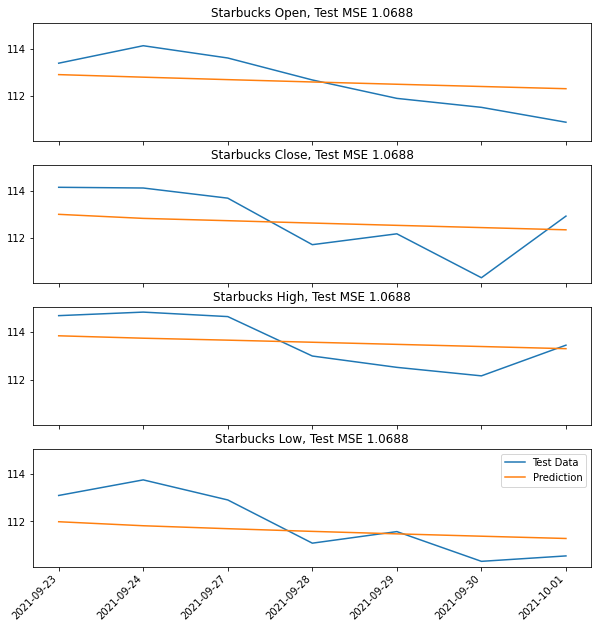

In [2]:
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import torch
import pandas as pd
## Import the data from Kaggle
history = pd.read_csv(r'../input/starbucks-stock-data-live-and-latest/Starbucks_stock_history.csv').set_index("Date")
X = history[["Open","Close", "High", "Low"]]
## Split the data for a time-series forecast
train_win = round(X.shape[0]-7)
X_train,X_test = X[:train_win], X[train_win:]
## Define a Training function for the Koopman operator approximation
def train_koopman_predict(X_train):
    ## Take the first m-1 columns
    if isinstance(X_train, pd.Series):
        X_train = X_train.values.T.reshape(1,-1)
    else:
        X_train = X_train.values.T
    X_1 = torch.tensor(X_train[:,:-1]).to(device)
    ## Take the last m - 1 columns
    X_2 = torch.tensor(X_train[:,1:]).to(device)
    ## Define the Koopman Operator approx.
    K = torch.mm(X_1, torch.linalg.pinv(X_2)).to(device)
    ## Helper function for predictions
    predict = lambda X : torch.mm(K,X)
    ## Loss on the training set
    train_loss = mse_loss(predict(X_1),X_2)
    return predict, train_loss
## Get the predictor
predict,train_loss = train_koopman_predict(X_train)
## The last value of the training set to predict the first value of the test set
X_0 = X_train.values.T[:,-1].reshape(-1,1)
X_0 = torch.tensor(X_0).to(device)
## Forecase based on the last value
predicted = [predict(X_0)]
for i in range(X_test.shape[0]-1):
    last_value = predicted[-1]
    predicted.append(predict(last_value))
## Collect the forecasts as a tensor
predicted = torch.cat(predicted, dim = 1).to(device)
## Convert X_test to a tensor
X_test = torch.tensor(X_test.values.T).to(device)
## Get test loss
test_loss = mse_loss(predicted, X_test)
## Plot
columns = X.columns
fig, ax = plt.subplots(len(columns),figsize = (10,10), sharex=True,sharey = True)
for i in range(len(ax)):
    ax[i].plot(range(X.shape[0] - train_win),X_test.cpu().numpy()[i], label = "Test Data")
    ax[i].plot(range(X.shape[0] - train_win),predicted.cpu().numpy()[i], label = "Prediction")
    ax[i].set_title("Starbucks {}, Test MSE {:.4f}".format(columns[i],test_loss))
    ax[i].set_xticks(ticks = range(X.shape[0] - train_win),labels = X[train_win:].index.values, rotation = 45, ha = "right")
#     ax[i].set_yticks()
plt.legend()
plt.show()
